In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
import datetime as dt

import keras as ks
import tensorflow as tf

import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
import sklearn.ensemble
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from mlxtend.plotting import plot_decision_regions

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import xgboost as xgb

### HELPER FUNCTIONS 

In [2]:
def get_popular_words(corpus, top_n):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    feature_array = vectorizer.get_feature_names()
    top_words = sorted(list(zip(vectorizer.get_feature_names(), X.sum(0).getA1())), key=lambda x: x[1], reverse=True)[:top_n]
    result = [x[0] for x in top_words]
    return result

In [3]:
def get_pw_from_file(filename, column, n_top):
    df = pd.read_csv(filename)
    df['all_text'] = df['headline'] + " " + df['abstract'] + " " + df['keywords']
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english')) 
    df[column] = df[column].astype(str)
    df = lemmatize_column(df, column, lemmatizer, stop_words)
    popular_words = get_popular_words(df[column], n_top)
    
    return popular_words

In [4]:
def process_sentence(sentence, lemmatizer, stop_words):
    sentence = sentence.lower()
    tokens = list(set(word_tokenize(sentence)))   
    words = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [5]:
def ord_encode(df, ordinal_features):
    # Ordinal encode all of these features
    ordinal = sklearn.preprocessing.OrdinalEncoder()
    df[ordinal_features] = ordinal.fit_transform(df[ordinal_features])
    return df

In [6]:
def encode_language_column(df, col_name, popular_words = []):
    vectorizer = CountVectorizer()
    nc = vectorizer.fit_transform(df[col_name])
    encoded_col = pd.DataFrame(nc.A, columns=vectorizer.get_feature_names())[popular_words]
    df = pd.concat([df.reset_index(drop=True), encoded_col.reset_index(drop=True)], axis=1)
    return df

In [7]:
def lemmatize_column(df, col_name, lemmatizer, stop_words):
    df[col_name] = df[col_name].map(lambda x: process_sentence(x, lemmatizer, stop_words))
    return df

In [8]:
def open_and_preprocess(filename):
    df = pd.read_csv(filename)    
    
    # create 3 new columns
    df['week_day'] = df['pub_date'].map(lambda x: pd.Timestamp.to_pydatetime(pd.Timestamp(x)).weekday())
    df['pub_hour'] = df['pub_date'].map(lambda x: pd.Timestamp.to_pydatetime(pd.Timestamp(x)).hour)
    df['all_text'] = df['headline'] + " " + df['abstract'] + " " + df['keywords']
    
    # ordinal encode
    df = ord_encode(df, ['newsdesk', 'section', 'material'])
    
    df = df.drop(['uniqueID', 'subsection', 'pub_date', 'headline', 'abstract', 'keywords'], axis=1)
    
    return df

In [9]:
def process_column(df, column, n_top, popular_words = []):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english')) 
    df[column] = df[column].astype(str)
    df = lemmatize_column(df, column, lemmatizer, stop_words)
    if len(popular_words) == 0:
        popular_words = get_popular_words(df[column], n_top)
    df = encode_language_column(df, column, popular_words)
    df = df.drop([column], axis=1)
    return df

In [29]:
def generate_cm(y_test, test_predictions, graph_title):
    mat = sklearn.metrics.confusion_matrix(y_test, test_predictions)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False) 
    plt.title(graph_title)
    plt.xlabel('true labels') 
    plt.ylabel('predicted labels')
    plt.savefig(graph_title + '.png')
    plt.show()
    plt.clf()

### OPTIMIZE 

In [11]:
def base_optimize_DT(X_train, y_train):    
    # Cross-validation folds
    k = 10

    # Hyperparameters to tune:
    params = {
                'min_samples_split': [2, 5, 10],
                'criterion': ['gini', 'entropy'],
                'max_depth': [5, 10, 20],
                'min_samples_leaf': [1, 2, 5, 10]
             }
    
    # Initialize GridSearchCV object with decision tree classifier and hyperparameters
    grid_tree = sklearn.model_selection.GridSearchCV(estimator=sklearn.tree.DecisionTreeClassifier(),
                             param_grid=params,
                             cv=k,
                             return_train_score=True,
                             scoring='accuracy',
                             refit='accuracy') 

    # Train and cross-validate, print results
    grid_tree.fit(X_train, y_train)

    best_hyperparams = grid_tree.best_params_

    # print best hyperparameters
    print("Optimized Decision Tree")
    print(best_hyperparams)
    return best_hyperparams

In [12]:
def base_optimize_KNN(X_train, y_train):
    ## Choose optimal k neighbors  
    # Cross-validation folds
    neighbors = []                                                              # Empty list to store neighbors
    cv_scores = []                                                              # Empty list to store scores

    # Perform 10-fold cross validation with K=5 for KNN (the n_neighbors parameter)
    for k in range(1, 51, 2):                                                   # Range of K we want to try
        neighbors.append(k) 
        knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors = k)           # k = 5 for KNeighborsClassifier
        scores = sklearn.model_selection.cross_val_score( 
            knn, X_train, y_train, cv = 10, scoring = 'accuracy') 
        cv_scores.append(scores.mean()) 

    # Misclassification error versus k
    MSE = [1-x for x in cv_scores]                                               # Changing to misclassification error

    # Determining the best k value
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('The optimal number of K neighbors = %d ' %optimal_k)

    # Plot misclassification error versus k
    plt.figure(figsize = (10,6))
    plt.plot(neighbors, MSE)
    plt.xlabel('Number of K neighbors')
    plt.ylabel('Misclassification Error')
    plt.show()
    plt.savefig('k_neighbors.png')
    plt.clf()

    # Hyperparameters to tune:
    params = {
                'n_neighbors': [19], 
                'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'weights': ['uniform', 'distance'],
             }
    
    # Initialize GridSearchCV object 
    grid_tree = sklearn.model_selection.GridSearchCV(estimator=sklearn.neighbors.KNeighborsClassifier(),
                             param_grid=params,
                             cv=10,
                             return_train_score=True,
                             scoring='accuracy',
                             refit='accuracy') 

    # Train and cross-validate, print results
    grid_tree.fit(X_train, y_train)

    best_hyperparams = grid_tree.best_params_

    # print best hyperparameters
    print("Optimized KNN")
    print(best_hyperparams)
    return best_hyperparams

In [13]:
def base_optimize_XGBM(X_train, y_train):    
    # Cross-validation folds
    k = 5

    # Hyperparameters to tune:
    params = {'booster': ['gblinear', 'gbtree', 'dart'],
              'n_estimators': [10, 25, 50],
              'max_depth': [5, 10, 20],
             }
    
    # Initialize GridSearchCV object
    grid_tree = sklearn.model_selection.GridSearchCV(estimator=xgb.XGBClassifier(),
                             param_grid=params,
                             cv=k,
                             return_train_score=True,
                             scoring='accuracy',
                             refit='accuracy') 

    # Train and cross-validate, print results
    grid_tree.fit(X_train, y_train)

    best_hyperparams = grid_tree.best_params_

    # print best hyperparameters
    print("Optimized XGBoost")
    print(best_hyperparams)
    return best_hyperparams

### PREPROCESSING [ALL TEXT]

In [14]:
n_top = 150
text_column_to_change = 'all_text'

# TRAIN SET 
df = open_and_preprocess("train.csv")
df = process_column(df, text_column_to_change, n_top)
y_train = df['is_popular']
# NOTE: REMOVING word_count DRASTICALLY IMPROVES ACCURACY
X_train = df.drop(['is_popular', 'n_comments', 'word_count'], axis=1)

# TEST SET 
ts = open_and_preprocess("test.csv")
ts = process_column(ts, text_column_to_change, n_top, get_pw_from_file('train.csv', text_column_to_change, n_top))
y_test = ts['is_popular']
X_test = ts.drop(['is_popular', 'word_count'], axis=1)

### MODEL TRAINING

In [15]:
# # OPTIMIZE SHALLOW MODELS
# base_optimize_DT(X_train, y_train)
# base_optimize_KNN(X_train, y_train)
# base_optimize_XGBM(X_train, y_train)

Decision Tree's test accuracy is 0.6620775969962454


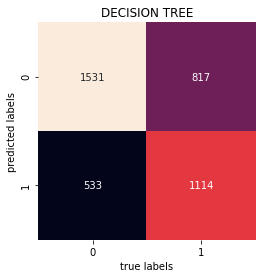

<Figure size 432x288 with 0 Axes>

In [30]:
# PREDICTING WITH DECISION TREE
tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10, min_samples_split=2)
tree.fit(X_train, y_train)
y_test_pred = tree.predict(X_test)
dt_accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred)
print(f"Decision Tree's test accuracy is {dt_accuracy}")
generate_cm(y_test, y_test_pred, "DECISION TREE")

KNN's test accuracy is 0.6868585732165207


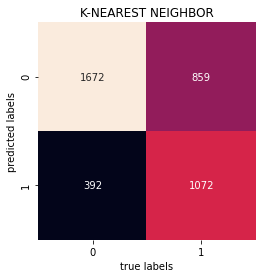

<Figure size 432x288 with 0 Axes>

In [31]:
# PREDICTING WITH KNN
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=19, weights='distance', algorithm='kd_tree')
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
knn_accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred)
print(f"KNN's test accuracy is {knn_accuracy}")
generate_cm(y_test, y_test_pred, "K-NEAREST NEIGHBOR")

In [25]:
# Train 2 different types of models and use soft voting to choose final classification
estimators = [('dt', sklearn.tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10, min_samples_split=2)),
              ('knn', sklearn.neighbors.KNeighborsClassifier(n_neighbors=19, weights='distance', algorithm='kd_tree'))]
vc = sklearn.ensemble.VotingClassifier(estimators=estimators, voting='soft')
scores = sklearn.model_selection.cross_val_score(vc, X_train, y_train, cv=10)
print('Voting Classifiers accuracy:', np.mean(scores))

Voting Classifiers accuracy: 0.7614126026192338


[11:50:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's test accuracy is 0.7121401752190237


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


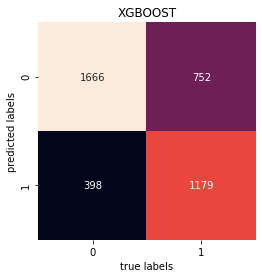

<Figure size 432x288 with 0 Axes>

In [32]:
# PREDICTING WITH XGBoost
boost = xgb.XGBClassifier(booster='gbtree', max_depth=10, n_estimators=25, use_label_encoder=False)
boost.fit(X_train, y_train)
y_test_pred = boost.predict(X_test)
boost_accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred)
print(f"XGBoost's test accuracy is {boost_accuracy}")
generate_cm(y_test, y_test_pred, "XGBOOST")

Epoch 1/20
218/218 [==============================] - 0s 2ms/step - loss: 0.6298 - accuracy: 0.6370 - val_loss: 0.5942 - val_accuracy: 0.6847
Epoch 2/20
218/218 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.7006 - val_loss: 0.5750 - val_accuracy: 0.6842
Epoch 3/20
218/218 [==============================] - 0s 1ms/step - loss: 0.5324 - accuracy: 0.7267 - val_loss: 0.5548 - val_accuracy: 0.7118
Epoch 4/20
218/218 [==============================] - 0s 1ms/step - loss: 0.5126 - accuracy: 0.7425 - val_loss: 0.5389 - val_accuracy: 0.7170
Epoch 5/20
218/218 [==============================] - 0s 2ms/step - loss: 0.5013 - accuracy: 0.7521 - val_loss: 0.5301 - val_accuracy: 0.7181
Epoch 6/20
218/218 [==============================] - 0s 2ms/step - loss: 0.4931 - accuracy: 0.7572 - val_loss: 0.5315 - val_accuracy: 0.7217
Epoch 7/20
218/218 [==============================] - 1s 2ms/step - loss: 0.4819 - accuracy: 0.7588 - val_loss: 0.5293 - val_accuracy: 0.7348
Epoch 

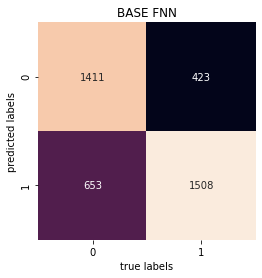

<Figure size 432x288 with 0 Axes>

In [33]:
# BASE MODEL - VERY SIMPLE FNN
fnn = ks.models.Sequential()
fnn.add(ks.layers.Flatten(input_shape=[X_train.shape[1]]))
fnn.add(ks.layers.Dense(64, activation="relu"))
fnn.add(ks.layers.Dense(32, activation="relu"))
fnn.add(ks.layers.Dense(16, activation="relu"))
fnn.add(ks.layers.Dense(8, activation="relu"))
fnn.add(ks.layers.Dense(2, activation="softmax"))

fnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
fnn.fit(X_train, y_train, batch_size=50, epochs=20, validation_split=0.15)
test_predictions = np.argmax(fnn.predict(X_test), axis=1)
fnn_accuracy = sklearn.metrics.accuracy_score(y_test, test_predictions)
print(f"FNN's test accuracy is {fnn_accuracy}")
generate_cm(y_test, test_predictions, "BASE FNN")

Epoch 1/30
90/90 [==============================] - 0s 4ms/step - loss: 0.6222 - accuracy: 0.6478 - val_loss: 0.5795 - val_accuracy: 0.6953
Epoch 2/30
90/90 [==============================] - 0s 3ms/step - loss: 0.5696 - accuracy: 0.7028 - val_loss: 0.5542 - val_accuracy: 0.7047
Epoch 3/30
90/90 [==============================] - 0s 3ms/step - loss: 0.5415 - accuracy: 0.7241 - val_loss: 0.5560 - val_accuracy: 0.7133
Epoch 4/30
90/90 [==============================] - 0s 4ms/step - loss: 0.5178 - accuracy: 0.7388 - val_loss: 0.5486 - val_accuracy: 0.7156
Epoch 5/30
90/90 [==============================] - 0s 2ms/step - loss: 0.5097 - accuracy: 0.7444 - val_loss: 0.5240 - val_accuracy: 0.7320
Epoch 6/30
90/90 [==============================] - 0s 2ms/step - loss: 0.4857 - accuracy: 0.7581 - val_loss: 0.5220 - val_accuracy: 0.7312
Epoch 7/30
90/90 [==============================] - 0s 3ms/step - loss: 0.4755 - accuracy: 0.7652 - val_loss: 0.5181 - val_accuracy: 0.7305
Epoch 8/30
90/90 [==

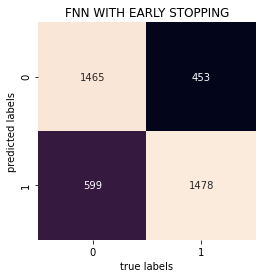

<Figure size 432x288 with 0 Axes>

In [34]:
# FNN WITH EARLY STOPPING
model = ks.models.Sequential([
    ks.layers.Flatten(input_shape=[X_train.shape[1]]),
    ks.layers.Dense(256, activation="relu"),
    ks.layers.Dense(128, activation="relu"),
    ks.layers.Dense(64, activation="relu"),
    ks.layers.Dense(32, activation="relu"),
    ks.layers.Dense(2, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=4, restore_best_weights=True)
model.fit(X_train, y_train, batch_size=128, epochs=30, validation_split=0.1, callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(X_test), axis=1)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)
print(f"The test accuracy is {test_accuracy}")
generate_cm(y_test, test_predictions, "FNN WITH EARLY STOPPING")

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

90/90 [==============================] - 0s 4ms/step - loss: 0.8666 - accuracy: 0.6093 - val_loss: 0.6187 - val_accuracy: 0.6766
Epoch 2/30
90/90 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.6771 - val_loss: 0.5794 - val_accuracy: 0.7055
Epoch 3/30
90/90 [==============================] - 0s 5ms/step - loss: 0.5498 - accuracy: 0.7136 - val_loss: 0.5413 - val_accuracy: 0.7156
Epoch 4/30
90/90 [==============================] - 0s 3ms/step - loss: 0.5371 - accurac

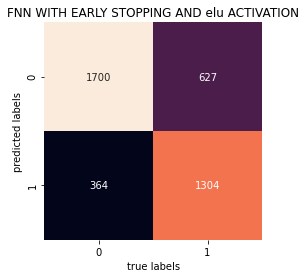

<Figure size 432x288 with 0 Axes>

In [35]:
# FNN WITH EARLY STOPPING AND elu ACTIVATION
np.random.seed(0)
tf.random.set_seed(1)

model = ks.models.Sequential([
    ks.layers.Dense(256, activation="elu", kernel_initializer="he_normal"),
    ks.layers.Dense(128, activation="elu", kernel_initializer="he_normal"),
    ks.layers.Dense(64, activation="elu", kernel_initializer="he_normal"),
    ks.layers.Dense(32, activation="elu", kernel_initializer="he_normal"),
    ks.layers.Dense(2, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=4, restore_best_weights=True)
model.fit(X_train, y_train, batch_size=128, epochs=30, validation_split=0.1, callbacks=[early_stopping_callback])

test_predictions = np.argmax(model.predict(X_test), axis=1)
test_accuracy = metrics.accuracy_score(y_test, test_predictions)
print(f"The test accuracy is {test_accuracy}")
generate_cm(y_test, test_predictions, "FNN WITH EARLY STOPPING AND elu ACTIVATION")

### MODEL ANALYSIS 

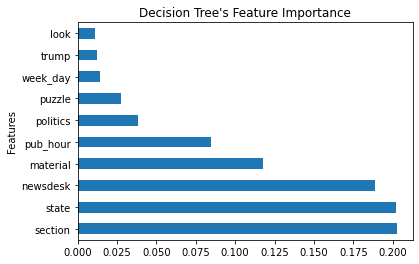

<Figure size 432x288 with 0 Axes>

In [22]:
# Feature importance of Decision Tree 
feat_importances = pd.Series(tree.feature_importances_, index=X_train.columns).nlargest(10)
feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')
plt.ylabel('Features')
plt.title("Decision Tree's Feature Importance")
plt.show()
plt.savefig('dt_feature_importance.png')
plt.clf()

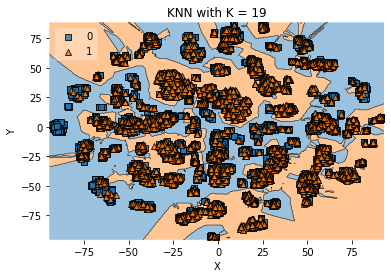

<Figure size 432x288 with 0 Axes>

In [23]:
# Plotting KNN decision region
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=19)
X_train2 = TSNE(n_components = 2).fit_transform(X_train)
clf.fit(X_train2, y_train)
plot_decision_regions(X_train2, y_train.values, clf=clf, legend=2)
# Adding axes annotations
plt.xlabel('X')
plt.ylabel('Y')
plt.title('KNN with K = 19')
plt.show()
plt.savefig('knn_surface.png')
plt.clf()

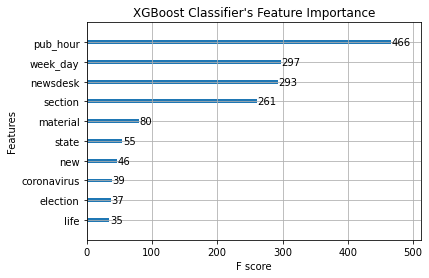

<Figure size 432x288 with 0 Axes>

In [23]:
# Show feature importance 
xgb.plot_importance(boost, max_num_features=10)
plt.title("XGBoost Classifier's Feature Importance")
plt.show()
plt.savefig('feature_importance.png')
plt.clf()

In [24]:
# Decision Tree's test accuracy is 0.6648310387984981
# KNN's test accuracy is 0.6868585732165207
# XGBoost's test accuracy is 0.7121401752190237
# FNN's test accuracy is 0.7531914893617021
# 218/218 [==============================] - 0s 1ms/step - loss: 0.3657 - accuracy: 0.8325 - val_loss: 0.5921 - val_accuracy: 0.7410